In [1]:
import os
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
from sklearn.utils import shuffle
import albumentations as A
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:

# Stap 1: Dataset laden
def load_dataset(dataset_dir):
    X, y = [], []
    label_map = {str(i): i for i in range(10)}
    
    for label_str in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label_str)
        if not os.path.isdir(label_path):
            continue

        for fname in os.listdir(label_path):
            img_path = os.path.join(label_path, fname)
            img = load_img(img_path, color_mode='grayscale', target_size=(64, 64))
            X.append(img_to_array(img) / 255.0)
            y.append(label_map[label_str])
    
    return np.array(X), np.array(y)

X, y = load_dataset("synthetic_digits/all")
X, y = shuffle(X, y, random_state=2003)

In [3]:
# Stap 3: Albumentations augmentatie
albumentations_transform = A.Compose([
    A.LongestMaxSize(128),
    # Vervanging voor ImageDataGenerator augmentaties:
    A.Rotate(limit=5),
    A.Affine(scale=(0.95, 1.05)),
    A.Affine(shear={"x": (-5, 5), "y": (-5, 5)}),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0, rotate_limit=0),
    A.Perspective(scale=(0.05, 0.1), keep_size=True, p=0.5),

    A.Resize(64, 64)
])


c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [4]:
# Stap 4: Hybride generator
class HybridAugmentGenerator(Sequence):
    def __init__(self, X, y, batch_size, albumentations_transform=None, keras_preprocessing_func=None, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.albu_transform = albumentations_transform
        self.keras_pre_func = keras_preprocessing_func
        self.shuffle = shuffle
        self.indices = np.arange(len(X))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = self.X[batch_indices]
        y_batch = self.y[batch_indices]
        X_aug = []

        for img in X_batch:
            if self.albu_transform:
                img = self.albu_transform(image=img.astype(np.float32))['image']
            if self.keras_pre_func:
                img = self.keras_pre_func(img)
            X_aug.append(img)

        return np.stack(X_aug), y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)



In [5]:
# 1. Shuffle en splitsen
from sklearn.model_selection import train_test_split

X_train_orig, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val_orig, X_test_orig, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 2. Realistische targets genereren
def generate_realistic_targets(X_part, albumentations_transform):
    batch_size = 32
    all_targets = []
    for i in range(0, len(X_part), batch_size):
        batch_imgs = X_part[i:i+batch_size]
        dummy_labels = np.zeros(len(batch_imgs))  # labels zijn nu niet relevant
        batch_gen = HybridAugmentGenerator(
            batch_imgs, dummy_labels, 
            batch_size=len(batch_imgs),
            albumentations_transform=albumentations_transform,
            shuffle=False
        )
        targets_batch, _ = batch_gen[0]
        all_targets.append(targets_batch)
    return np.vstack(all_targets)


# Targets maken
# Stel je hebt een albumentations_transform gedefinieerd
train_targets = generate_realistic_targets(X_train_orig, albumentations_transform)
val_targets = generate_realistic_targets(X_val_orig, albumentations_transform)
test_targets = generate_realistic_targets(X_test_orig, albumentations_transform)


np.save("train_targets2.npy", train_targets)
np.save("val_targets2.npy", val_targets)
np.save("test_targets2.npy", test_targets)

# Later:
train_targets = np.load("train_targets2.npy")
val_targets = np.load("val_targets2.npy")
test_targets = np.load("test_targets2.npy")



In [7]:
np.save("y_train_targets2.npy", y_train)
np.save("y_val_targets2.npy", y_val)
np.save("y_test_targets2.npy", y_test)


In [9]:
y_train_targets = np.load("y_train_targets2.npy")
y_val_targets = np.load("y_val_targets2.npy")
y_test_targets = np.load("y_test_targets2.npy")


# Voorbeeld output:

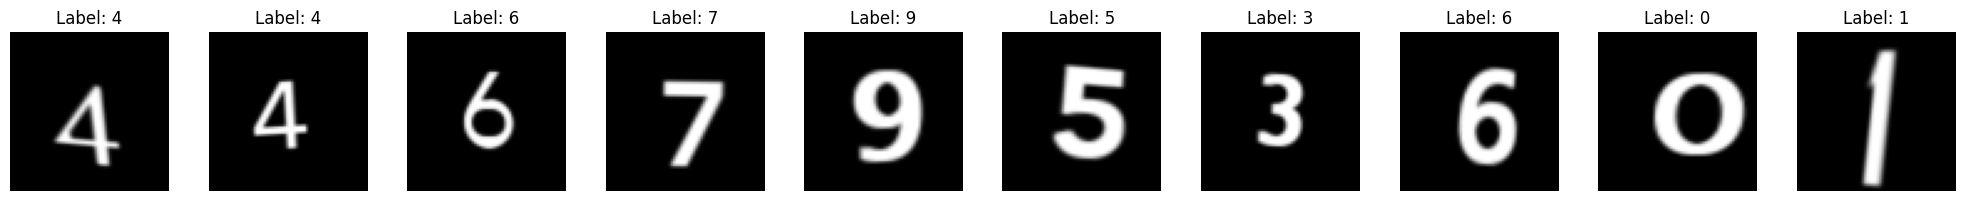

In [ ]:
n = 10

plt.figure(figsize=(20, 2))  

# Loop door 10 afbeeldingen
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(train_targets[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train_targets[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
